## CSE 6367 Programming Assignment 4 (P4)
## Fall 2023
## Panorama

## Dataset

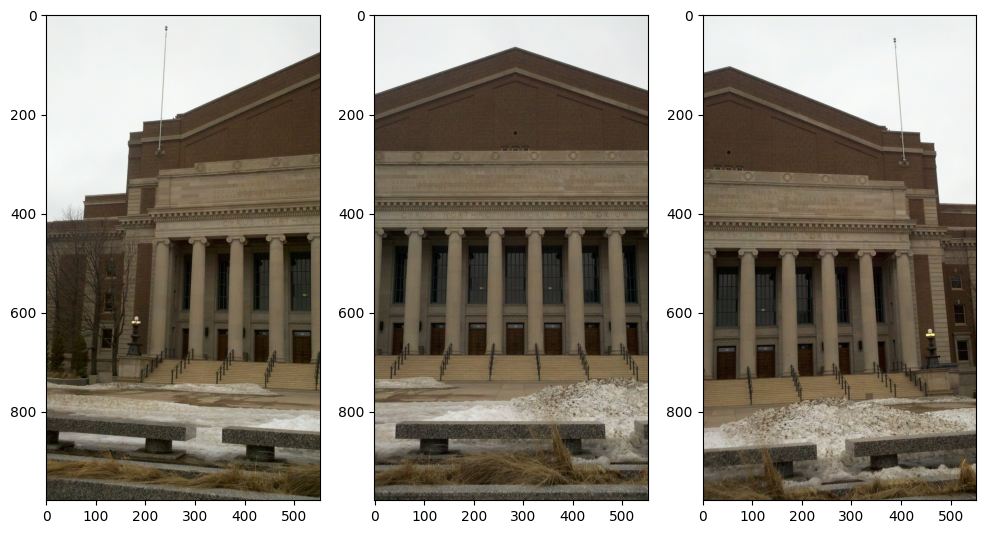

In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams


%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 12 ,8

# read images
img1 = cv2.imread("Images/mall1.jpg")
img2 = cv2.imread("Images/mall2.jpg")
img3 = cv2.imread("Images/mall3.jpg")

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# display images
fig, ax = plt.subplots(1,3)
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3)

## Assignment Instructions:

In this assignment, you will perform image stitching and create a panorama of stitched images. Here are some basic steps you need to perform for image stiching:

    1. Detecting keypoints (DoG, Harris, etc.) and extracting local invariant descriptors (SIFT, SURF, ORB etc.) from two input images
    2. Matching the descriptors between the images
    3. Estimate a homography matrix using our matched feature vectors
    4. Applying a warping transformation using the homography matrix obtained from Step #3
    
<b> You may use opencv or other libraries for doing different tasks of this programming assignment.<\b>

## Step 1: Detecting Keypoints using SIFT

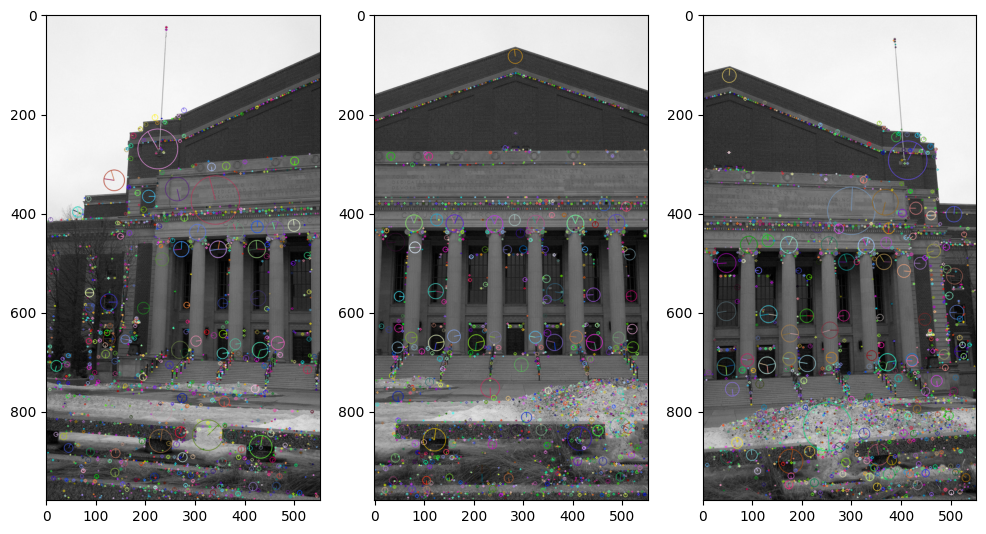

In [71]:
# Creatign subplots for the visualization of the images with the key points and descriptors that are identified by the SIFT method.
figure, axes  = plt.subplots(1, 3, figsize = (12, 12))

# Reading the image data.
left_img = cv2.imread('./Images/mall1.jpg')
cent_img = cv2.imread('./Images/mall2.jpg')
right_img = cv2.imread('./Images/mall3.jpg')

# Converting the images to Grayscale images.
"""
This is done for several reasons that includes to make the images invarint to the illumination, for simplicity purposes, dimensionality reduction etc.
"""
left_gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
cent_gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
right_gray = cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY)

# Iniializing the SiFIt to find the key points and the descriptors.
"""
nfeatures is set to 0 to find maximum number of features.
"""
sift = cv2.SIFT_create(nfeatures = 0)

# Finding keypoints and descriptors from each image.
"""
Setting mask to None will allow SIFT object to find information from the whole image.
"""
keyPoint1, Desc1 = sift.detectAndCompute(left_gray, None)
keyPoint2, Desc2 = sift.detectAndCompute(cent_gray, None)
keyPoint3, Desc3 = sift.detectAndCompute(right_gray, None)

# Drawing key points on the top of the image.
"""
flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS specifies how the keypoints should be drawn.
"""
left_imgk = cv2.drawKeypoints(left_gray, keyPoint1, left_img, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cent_imgk = cv2.drawKeypoints(cent_gray, keyPoint2, cent_img, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
right_imgk = cv2.drawKeypoints(right_gray, keyPoint3, right_img, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Displaying the images.
axes[0].imshow(left_imgk)
axes[1].imshow(cent_imgk)
axes[2].imshow(right_imgk)
plt.show()

## Step 2: Matching the descriptors between the images.

### Matching the left and center image

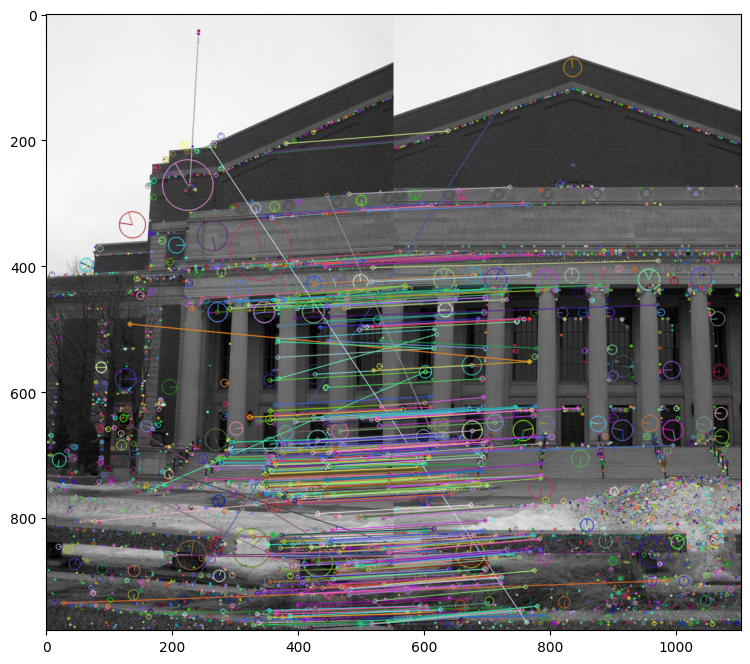

In [72]:
# Creating an object for the Brute-Force Matcher.
bruteF = cv2.BFMatcher()

# Finding the matches between the left and center images descriptor information.
"""
- Setting k = 2 which means for each descriptor in the left image we are finidng two nearest neighbors from the center image.
"""
Matches_LC = bruteF.knnMatch(Desc1, Desc2, k = 2)

# Creating a list to store all the good matches between the left and center images.
good_match_LC = []

# Iterating through the Matches to find teh good matches so that we can combine them into a single image.
for m, n in Matches_LC:
    if m.distance < (0.75 * n.distance):
        good_match_LC.append([m])
    else: pass

# Finding the combined image with the good matches.
left_cent_img = cv2.drawMatchesKnn(left_imgk, keyPoint1, cent_imgk, keyPoint2, good_match_LC, None, flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Displaying the image without keypoint matching lines.
plt.imshow(left_cent_img)


### Matching the center and right image.

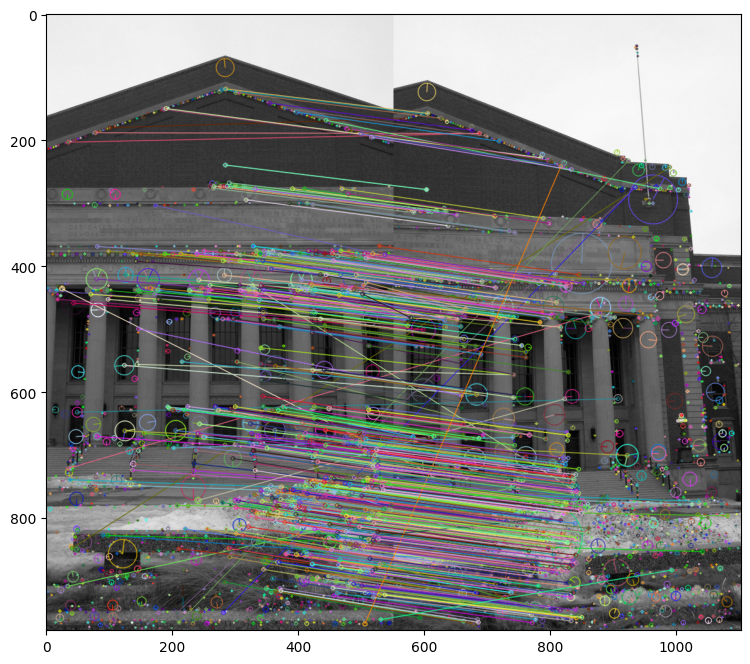

In [73]:
# Finding the matches between the left and center images descriptor information.
"""
- Setting k = 2 which means for each descriptor in the left image we are finidng two nearest neighbors from the center image.
"""
Matches_CR = bruteF.knnMatch(Desc2, Desc3, k = 2)

# Creating a list to store all the good matches between the left and center images.
good_match_CR = []

# Iterating through the Matches to find teh good matches so that we can combine them into a single image.
for m, n in Matches_CR:
    if m.distance < (0.80 * n.distance):
        good_match_CR.append([m])
    else: pass

# Finding the combined image with the good matches.
cent_right_img = cv2.drawMatchesKnn(cent_imgk, keyPoint2, right_imgk, keyPoint3, good_match_CR, None, flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Displaying the image without keypoint matching lines.
plt.imshow(cent_right_img)

## Step 3: Finding the Homography matrix

### Finding the Homography Matrix for the left and center image.

In [74]:
# Finding the source points from the keypoints of the left and the center images.
sourcePoints_LC = np.float32([keyPoint1[Matches_LC.index(m)].pt for m in Matches_LC]).reshape(-1, 1, 2)

# Finding the destination points from the keypoints of the right and the center images.
destPoints_LC = np.float32([keyPoint2[Matches_LC.index(m)].pt for m in Matches_LC]).reshape(-1, 1, 2)

# Finding the homography transformation matrix to wrap around the source and destination points.
homo_LC, Mask_LC = cv2.findHomography(sourcePoints_LC, destPoints_LC, cv2.RANSAC, 5.0)

### Finding the homography matrix for the center and the right image.

In [75]:
# Finding the source points from the keypoints of the left and the center images.
sourcePoints_CR = np.float32([keyPoint2[Matches_CR.index(m)].pt for m in Matches_CR]).reshape(-1, 1, 2)

# Finding the destination points from the keypoints of the right and the center images.
destPoints_CR = np.float32([keyPoint3[Matches_CR.index(m)].pt for m in Matches_CR]).reshape(-1, 1, 2)

# Finding the homography transformation matrix to wrap around the source and destination points.
homo_CR, Mask_CR = cv2.findHomography(sourcePoints_CR, destPoints_CR, cv2.RANSAC, 5.0)

## Step 4: Applying a wrapping transformation using the homography matrix.

### Applying wrapping transformation for the left and center image.

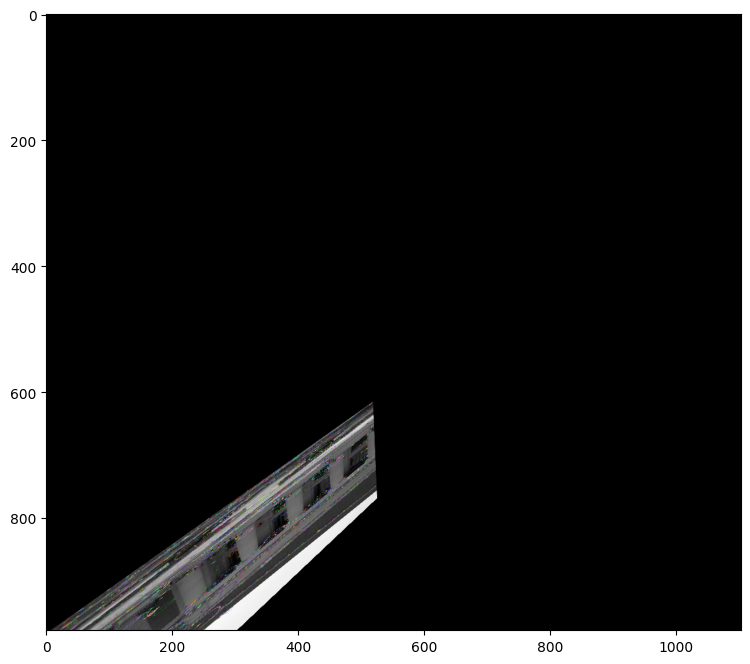

In [76]:
# Apply a warping transformation to  using the homography matrix
wrapped_image = cv2.warpPerspective(left_img, homo_LC, (left_img.shape[1] + cent_img.shape[1], left_img.shape[0]))
plt.imshow(wrapped_image)

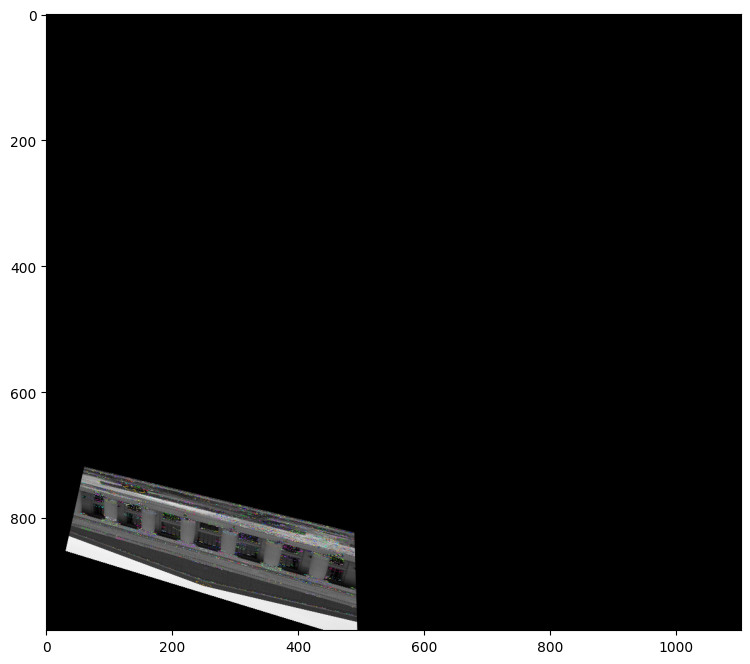

In [77]:
# Apply a warping transformation to one of the images using the homography matrix
wrapped_image = cv2.warpPerspective(cent_img, homo_CR, (cent_img.shape[1] + right_img.shape[1], cent_img.shape[0]))
plt.imshow(wrapped_image)

## Creating panorama using OpenCV

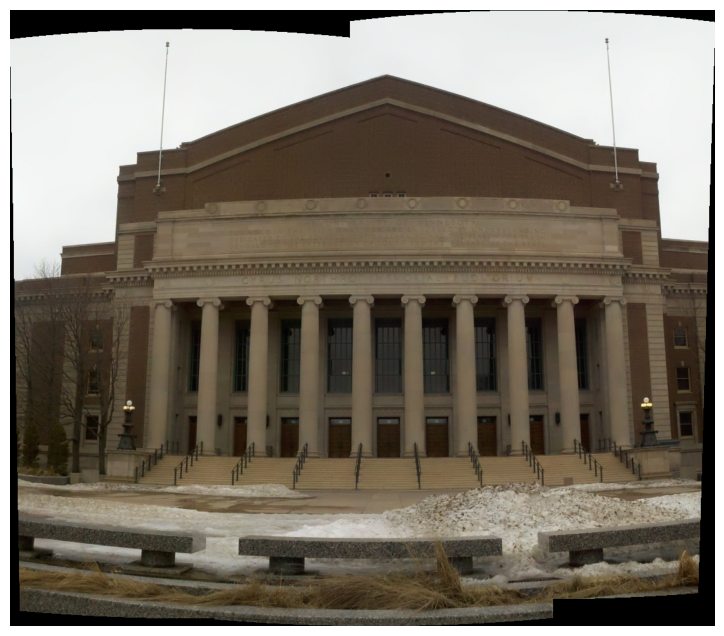

In [78]:
# Reading the image data.
left_img = cv2.imread('./Images/mall1.jpg')
cent_img = cv2.imread('./Images/mall2.jpg')
right_img = cv2.imread('./Images/mall3.jpg')

# Initializing the OpenCV image stitcher.
stitcher = cv2.Stitcher_create()

# Stitching the left, center and right images together.
status, panorama = stitcher.stitch((left_img, cent_img, right_img))

if status == cv2.Stitcher_OK:
    # Stitching was successful
    # Convert and display the stitched image
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Turn off axis
    plt.show()
else:
    # Stitching failed
    print("Stitching failed with status code:", status)


### Submission Guidelines:
        
        Submit through Canvas your source code in a single .ipynb file. 
        The name of the .ipynb file should be YourStudentID.ipynb. (For example: 1001234567.ipynb)
        The images are available in the ./Images directory. Your TA will use the same directory name to grade your submission.
        You don't need to attach the images folder with your submission.